Import package
=====================

In [1]:
pip install pytorch-nlp

     |████████████████████████████████| 92kB 2.3MB/s 


In [4]:
import torch
from torchnlp.word_to_vector import GloVe
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd.variable import Variable
import seaborn as sns
import numpy as np

Import dataset
=========================

In [5]:
numwords = 50000
max = 200
from tensorflow.keras.datasets import imdb
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) \
= imdb.load_data(num_words=numwords, skip_top=50, maxlen=100)
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items() if i < numwords}

In [6]:
Y_train = torch.from_numpy(Y_train_numpy).type(torch.float).cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.float).cuda()
print(f"Y_train is {Y_train.size()}, Y_test is {Y_test.size()}")

Y_train is torch.Size([2773]), Y_test is torch.Size([2963])


In [ ]:
Y_train[0].view(1).size()

torch.Size([1])

Import Glove
======================= 

In [7]:
glove = GloVe(name='6B', dim=50)

glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|██████████| 400000/400000 [00:13<00:00, 29532.57it/s]


In [8]:
glove[',jalgja']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

RNN1
=========================
input_size = the length of word2vec  
hidden_size = casual  

hidden = concat(input, hidden) * H + b  
output = hidden * V + c

In [14]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size = hidden_size
        self.i2h = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size))
        self.i2o = nn.Sequential(
            nn.Linear(hidden_size, output_size))
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 0)
        hidden = self.tanh(self.i2h(combined))
        output = self.i2o(hidden)
        
        return hidden, output

    def initHidden(self):
        return torch.zeros(self.hidden_size)

Logistic Regression
========================

In [10]:
class Logistic(nn.Module):
    def __init__(self):
        super(Logistic, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear(x))
        return x

Implement
=================

for RNN1 (take final output)
--------------------


epoch is 0, acc_rate is 0.42



epoch is 1, acc_rate is 0.55



epoch is 2, acc_rate is 0.59



epoch is 3, acc_rate is 0.58



epoch is 4, acc_rate is 0.58



epoch is 5, acc_rate is 0.58



epoch is 6, acc_rate is 0.61



epoch is 7, acc_rate is 0.61



epoch is 8, acc_rate is 0.61



epoch is 9, acc_rate is 0.62



epoch is 10, acc_rate is 0.63



epoch is 11, acc_rate is 0.64



epoch is 12, acc_rate is 0.65



epoch is 13, acc_rate is 0.67



epoch is 14, acc_rate is 0.69



epoch is 15, acc_rate is 0.72



epoch is 16, acc_rate is 0.76



epoch is 17, acc_rate is 0.77



epoch is 18, acc_rate is 0.78



epoch is 19, acc_rate is 0.77



epoch is 20, acc_rate is 0.8



epoch is 21, acc_rate is 0.82



epoch is 22, acc_rate is 0.84



epoch is 23, acc_rate is 0.88



epoch is 24, acc_rate is 0.91



epoch is 25, acc_rate is 0.93



epoch is 26, acc_rate is 0.96



epoch is 27, acc_rate is 0.99



epoch is 28, acc_rate is 1.0



epoch is 29, acc_rate is 1.0



epoch is 30, acc_rate is 1.0



epoch is 31, acc_rate is 1.0



epoch is 32, acc_rate is 1.0



epoch is 33, acc_rate is 1.0



epoch is 34, acc_rate is 1.0



epoch is 35, acc_rate is 1.0



epoch is 36, acc_rate is 1.0



epoch is 37, acc_rate is 1.0



epoch is 38, acc_rate is 1.0



epoch is 39, acc_rate is 1.0


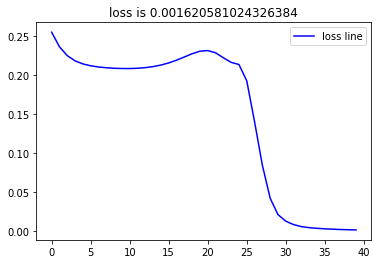

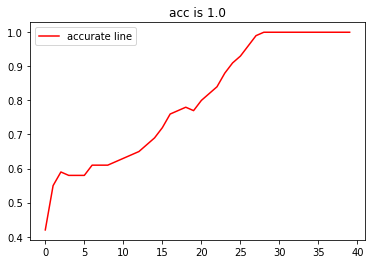

In [15]:
from tqdm.notebook import tnrange, tqdm_notebook


rnn1 = RNN1(50, 500, 1).cuda()
lr1 = Logistic().cuda()
rnn1_optimizer = optim.SGD(rnn1.parameters(), lr = 0.001, momentum=0.9)
lr1_optimizer = optim.SGD(lr1.parameters(), lr = 0.001, momentum=0.9)

# loss function
loss_function = nn.MSELoss()

# init acc
acc = 0

# list
epoch_list = []
loss_list = []
acc_rate_list = []

for ep in range(40):

    acc = 0

    for i in tnrange(100):

        # initial hidden layer
        hidden_layer = rnn1.initHidden().cuda()
        # initial learnable parameters
        rnn1.zero_grad()
        lr1.zero_grad()
        
        for word in [id2word[id] for id in X_train_numpy[i]]:

            # get word embedding
            wordEmbedding = glove[word].cuda()

            # forward
            hidden_layer, output_layer = rnn1(wordEmbedding, hidden_layer)
        
        # put final output through logistic regression
        out = lr1(output_layer)
        loss = loss_function(out, Y_train[i].view(1))
        loss.backward()
        rnn1_optimizer.step()
        lr1_optimizer.step()

        # calculate accurate rate
        pred = np.round(out.cpu().detach().numpy())
        if pred[0] == Y_train[i].cpu().detach().numpy():
            acc += 1
    
    acc_rate = acc / 100
    print(f"epoch is {ep}, acc_rate is {acc_rate}")

    epoch_list.append(ep)
    loss_list.append(loss.item())
    acc_rate_list.append(acc_rate)

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
plt.title(f"loss is {loss.item()}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
plt.title(f"acc is {acc_rate}")
plt.show()

In [17]:
acc = 0
for i in tnrange(1000):

    hidden_layer = rnn1.initHidden().cuda()
    
    for word in [id2word[id] for id in X_test_numpy[i]]:

        # get word embedding
        wordEmbedding = glove[word].cuda()

        # forward
        hidden_layer, output_layer = rnn1(wordEmbedding, hidden_layer)
    
    # put final output through logistic regression
    out = lr1(output_layer)

    # calculate accurate rate
    pred = np.round(out.cpu().detach().numpy())
    if pred[0] == Y_test[i].cpu().detach().numpy():
        acc += 1

acc_rate = acc / 1000
print(f"acc_rate is {acc_rate}")


acc_rate is 5.34
